#### Initial Data Cleaning

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\Riley_O'Rorke_Capstone_Data.xlsx"
df = pd.read_excel(file_path, header=0)  # Ensure headers are recognized

# Convert measurement values to numeric
measurement_column = 'C.[DataValue]'
df[measurement_column] = pd.to_numeric(df[measurement_column], errors='coerce')

# Convert timestamps to proper datetime format and ensure they remain datetime objects
timestamp_column = 'C.[EntryTimestamp]'
df[timestamp_column] = pd.to_datetime(df[timestamp_column], errors='coerce')
df = df.dropna(subset=[timestamp_column])  # Drop rows with invalid timestamps

# Ensure timestamps are saved as actual datetime objects (not strings)
df[timestamp_column] = pd.to_datetime(df[timestamp_column], errors='coerce')

# Sort data in chronological order
df = df.sort_values(by=timestamp_column, ascending=True).reset_index(drop=True)

# Drop missing values in measurement column (optional, based on data handling preference)
df = df.dropna(subset=[measurement_column])

# Save cleaned dataset for further analysis
output_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\cleaned_data.xlsx"
df.to_excel(output_path, index=False, engine='openpyxl')

# Display results
print("First 5 rows after preprocessing:")
print(df.head())



First 5 rows after preprocessing:
   D.[AssemblyName] D.[NamePostfix]                 F.[Name]  \
0          D0449376        UCL Boom  Mag 5 (Zone 1) - In Use   
1          D0449434        UCL Boom  Mag 5 (Zone 1) - In Use   
2          D0449393        UCL Boom  Mag 5 (Zone 1) - In Use   
3          D0445093        UCL Boom  Mag 5 (Zone 1) - In Use   
4          D0445057        UCL Boom  Mag 5 (Zone 1) - In Use   

   G1.[ParameterID]     G1.[Name]   G1.[OperatorMessage]  G2.[ParameterID]  \
0             22175  Scan Barcode  Scan the Boom Barcode             22176   
1             22175  Scan Barcode  Scan the Boom Barcode             22176   
2             22175  Scan Barcode  Scan the Boom Barcode             22176   
3             22175  Scan Barcode  Scan the Boom Barcode             22176   
4             22175  Scan Barcode  Scan the Boom Barcode             22176   

              G2.[Name]                           G2.[Description]  \
0  Retrieve Part Number  This pulls the AT

#### Exploratory Data Analysis

Total Detected Failures: 276
Date Range: 2021-12-20 09:39:04.333000 to 2025-02-21 11:02:44.283000
Average Failures Per Day: 0.48


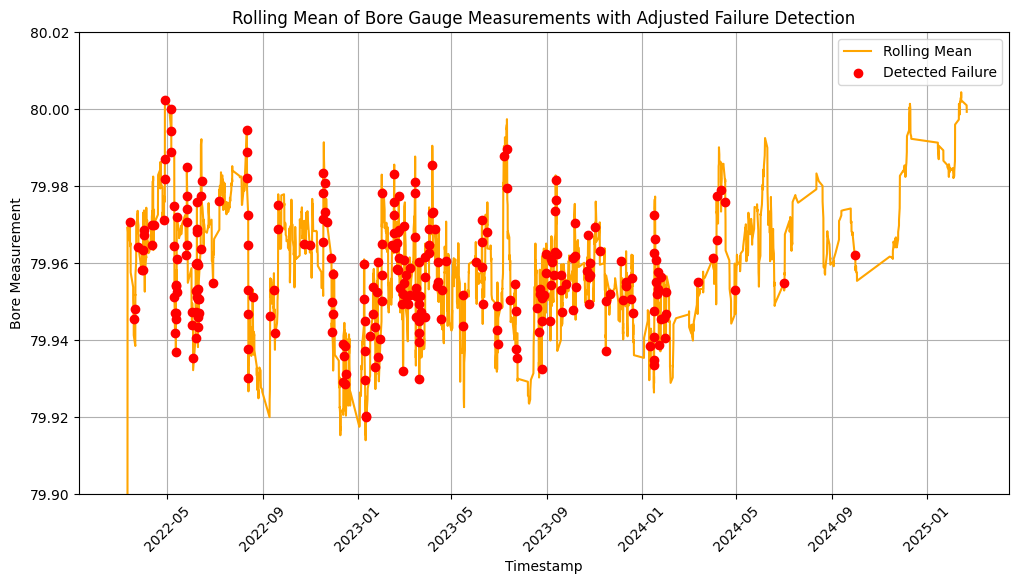

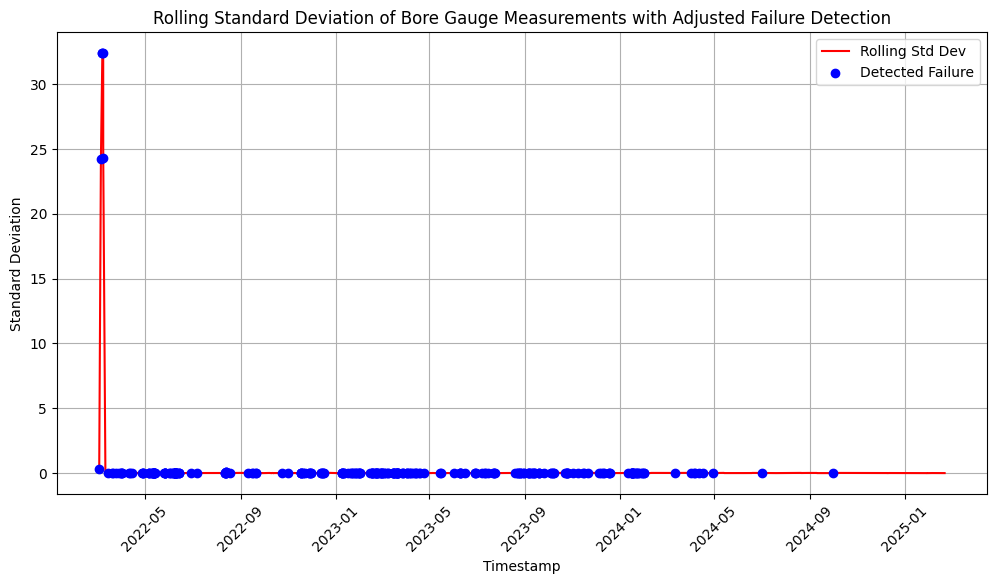

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute Rolling Mean and Standard Deviation
window_size = 10  # Adjust as needed
df['Rolling_Mean'] = df['C.[DataValue]'].rolling(window=window_size).mean()
df['Rolling_Std'] = df['C.[DataValue]'].rolling(window=window_size).std()

# Adjusted Failure Detection Parameters
mean_threshold = 0.005  # Lowered to detect more subtle shifts
std_threshold = 0.015   # Lowered to catch smaller fluctuations
df['Failure_Flag'] = ((df['Rolling_Mean'].diff().abs() > mean_threshold) & 
                       (df['Rolling_Std'] > std_threshold))

# Count the number of detected failures
num_failures = df['Failure_Flag'].sum()
print(f"Total Detected Failures: {num_failures}")

# Compute the date range
start_date = df['C.[EntryTimestamp]'].min()
end_date = df['C.[EntryTimestamp]'].max()
print(f"Date Range: {start_date} to {end_date}")

# Compute the average failures per day
df['Date'] = df['C.[EntryTimestamp]'].dt.date
failures_per_day = df.groupby('Date')['Failure_Flag'].sum()
avg_failures_per_day = failures_per_day.mean()
print(f"Average Failures Per Day: {avg_failures_per_day:.2f}")

# Plot Rolling Mean with Failure Flags
plt.figure(figsize=(12, 6))
plt.plot(df['C.[EntryTimestamp]'], df['Rolling_Mean'], color='orange', label='Rolling Mean')
plt.scatter(df['C.[EntryTimestamp]'][df['Failure_Flag']], 
            df['Rolling_Mean'][df['Failure_Flag']], 
            color='red', label='Detected Failure', zorder=3)
plt.xlabel('Timestamp')
plt.ylabel('Bore Measurement')
plt.title('Rolling Mean of Bore Gauge Measurements with Adjusted Failure Detection')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.ylim(79.90, 80.02)
plt.show()

# Plot Rolling Standard Deviation with Failure Flags
plt.figure(figsize=(12, 6))
plt.plot(df['C.[EntryTimestamp]'], df['Rolling_Std'], color='red', label='Rolling Std Dev')
plt.scatter(df['C.[EntryTimestamp]'][df['Failure_Flag']], 
            df['Rolling_Std'][df['Failure_Flag']], 
            color='blue', label='Detected Failure', zorder=3)
plt.xlabel('Timestamp')
plt.ylabel('Standard Deviation')
plt.title('Rolling Standard Deviation of Bore Gauge Measurements with Adjusted Failure Detection')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

with pd.ExcelWriter("G:\\College\\University of Montana\\Semester 4\\Capstone\\MSBA-Capstone-Riley-ORorke\\data\\eda_processed_data.xlsx", engine='openpyxl', mode='w') as writer:
    df.to_excel(writer, index=False)


#### Feature Engineering

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset (assuming it's already processed with failures detected in EDA)
file_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\eda_processed_data.xlsx"
df = pd.read_excel(file_path, parse_dates=['C.[EntryTimestamp]'])

# Ensure timestamps remain in datetime format
df['C.[EntryTimestamp]'] = pd.to_datetime(df['C.[EntryTimestamp]'], errors='coerce')

# Generate Cycle Count That Resets on Failure
df['Cycle_Count'] = 0
failure_indices = df.index[df['Failure_Flag']].tolist()
for i in range(len(failure_indices) - 1):
    start_idx, end_idx = failure_indices[i], failure_indices[i + 1]
    df.loc[start_idx:end_idx, 'Cycle_Count'] = range(0, end_idx - start_idx + 1)

# Compute Time Since Last Failure
df['Time_Since_Last_Failure'] = df['C.[EntryTimestamp]'].diff().dt.total_seconds()
df['Time_Since_Last_Failure'] = df.groupby(df['Failure_Flag'].cumsum())['Time_Since_Last_Failure'].cumsum()
df['Time_Since_Last_Failure'] = df['Time_Since_Last_Failure'].fillna(0)

# Compute Rolling Slope of Bore Measurements
window_size = 10  # Same as EDA window size
df['Rolling_Slope'] = df['C.[DataValue]'].diff().rolling(window=window_size).mean()

# Compute Rolling Range (Max-Min over a window)
df['Rolling_Range'] = df['C.[DataValue]'].rolling(window=window_size).max() - df['C.[DataValue]'].rolling(window=window_size).min()

# Compute Mean & Standard Deviation of Last N Cycles
df['Rolling_Mean_Cycles'] = df['C.[DataValue]'].rolling(window=window_size).mean()
df['Rolling_Std_Cycles'] = df['C.[DataValue]'].rolling(window=window_size).std()

# Drop NaN values caused by rolling operations
df.dropna(subset=['Rolling_Slope', 'Rolling_Range', 'Rolling_Mean_Cycles', 'Rolling_Std_Cycles'], inplace=True)

# Save as Excel for compatibility
df.to_excel(r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\feature_engineered_data.xlsx", index=False, engine='openpyxl')

# Display Sample Data
print("First 5 Rows of Feature-Engineered Data:")
print(df.head())


First 5 Rows of Feature-Engineered Data:
    D.[AssemblyName] D.[NamePostfix]                 F.[Name]  \
10          D0445102        UCL Boom  Mag 5 (Zone 1) - In Use   
11          D0445068        UCL Boom  Mag 5 (Zone 1) - In Use   
12          D0445110        UCL Boom  Mag 5 (Zone 1) - In Use   
13          D0445069        UCL Boom  Mag 5 (Zone 1) - In Use   
14          D0445066        UCL Boom  Mag 5 (Zone 1) - In Use   

    G1.[ParameterID]     G1.[Name]   G1.[OperatorMessage]  G2.[ParameterID]  \
10             22175  Scan Barcode  Scan the Boom Barcode             22176   
11             22175  Scan Barcode  Scan the Boom Barcode             22176   
12             22175  Scan Barcode  Scan the Boom Barcode             22176   
13             22175  Scan Barcode  Scan the Boom Barcode             22176   
14             22175  Scan Barcode  Scan the Boom Barcode             22176   

               G2.[Name]                           G2.[Description]  \
10  Retrieve Part Numb

#### Correlation Analysis

In [ ]:
import pandas as pd

# Load the dataset
file_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\feature_engineered_data.xlsx"
df = pd.read_excel(file_path)

# Drop categorical and non-numeric columns
non_numeric_columns = [
    " D.[AssemblyName]", "D.[NamePostfix]", "F.[Name]", 
    "G1.[Name]", "G1.[OperatorMessage]", "G2.[Name]", "G2.[Description]", 
    "G3.[Name]", "G3.[OperatorMessage]", "A.[Description]", 
    "B.[Description]", "B.[DataValue]", "A.[DataValue]", "Date"
]
df = df.drop(columns=[col for col in non_numeric_columns if col in df.columns], errors='ignore')

# Convert timestamps to numeric values (days since first entry)
for col in ["A.[EntryTimestamp]", "B.[EntryTimestamp]", "C.[EntryTimestamp]"]:
    df[col] = (df[col] - df[col].min()).dt.total_seconds()

# Convert Failure_Flag to integer (0=False, 1=True)
df["Failure_Flag"] = df["Failure_Flag"].astype(int)

# Drop the last remaining non-numeric column
df = df.drop(columns=["D.[AssemblyName]"], errors='ignore')

# Drop irrelevant features with NaN correlation
drop_columns = ["G1.[ParameterID]", "G2.[ParameterID]", "A.[ParameterID]", "B.[ParameterID]", "C.[MinValue]", "C.[MaxValue]"]
df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

# Compute correlation with Failure_Flag
if 'Failure_Flag' in df.columns:
    print("\n Final Correlation with Failure_Flag:")
    print(df.corr()['Failure_Flag'].sort_values(ascending=False))

# Save the processed dataset for model training
output_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\feature_selected_data.xlsx"
df.to_excel(output_path, index=False, engine='openpyxl')




 Final Correlation with Failure_Flag:
Failure_Flag               1.000000
Rolling_Range              0.079486
Rolling_Std_Cycles         0.073394
Rolling_Std                0.073394
G3.[ParameterID]          -0.029848
C.[ParameterID]           -0.029848
Rolling_Slope             -0.030910
Rolling_Mean_Cycles       -0.064950
Rolling_Mean              -0.064950
C.[DataValue]             -0.080717
C.[EntryTimestamp]        -0.122683
B.[EntryTimestamp]        -0.122842
A.[EntryTimestamp]        -0.122842
Time_Since_Last_Failure   -0.149223
Cycle_Count               -0.209646
Name: Failure_Flag, dtype: float64

✅ Feature selection completed. Dataset saved for model training.


#### Model Training

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the feature-selected dataset
file_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\feature_selected_data.xlsx"
df = pd.read_excel(file_path)

# Define the new target variable for Healthy vs Needs Maintenance
def classify_cycles(row):
    # Adjust these thresholds based on your criteria
    if row["Rolling_Range"] > 0.5 or row["Rolling_Std"] > 0.2:
        return "Needs Maintenance"
    else:
        return "Healthy"

df["Cycle_Status"] = df.apply(classify_cycles, axis=1)

# Separate features and the new target variable
X = df.drop(columns=["Cycle_Status"])
y = df["Cycle_Status"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the model
import joblib
model_output_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\cycle_classification_model.pkl"
joblib.dump(model, model_output_path)



Confusion Matrix:
[[650   0]
 [  1   0]]

Classification Report:
                   precision    recall  f1-score   support

          Healthy       1.00      1.00      1.00       650
Needs Maintenance       0.00      0.00      0.00         1

         accuracy                           1.00       651
        macro avg       0.50      0.50      0.50       651
     weighted avg       1.00      1.00      1.00       651



C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_cla

['G:\\College\\University of Montana\\Semester 4\\Capstone\\MSBA-Capstone-Riley-ORorke\\data\\cycle_classification_model.pkl']